In [1]:
import supervision_tools as svt
import ultralytics_tools as ult
import cv2
import matplotlib.pyplot as plt
from transformers import pipeline
import mivolo.predictor as mivolo
from PIL import Image
import torch
import numpy as np
from types import SimpleNamespace
import pandas as pd

pipe = pipeline("image-classification", model="dima806/facial_emotions_image_detection")
pose_model = ult.run_yolo_model('yolov8n', task='pose', format='onnx')




USING DEVICE: cpu


Running Model yolov8n in format onnx
Using IOU: 0.4 and CONF: 0.3





# MIVOLO CONFIGURATIONS

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = {
    'detector_weights': 'src/models/mivolo_weights.pt',
    'checkpoint': 'src/models/mivolo_checkpoints.tar',
    'device': device,
    'with_persons': True,
    'disable_faces': False,
    'draw': True,
}
config = SimpleNamespace(**config)

face_person_model = mivolo.Predictor(config, verbose=False)

annotation = svt.annotations()
tracker = svt.ByteTrack()
timers = svt.ClockBasedTimer()

Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


# START INFERENCE

Faces detected: 3
Persons detected: 2


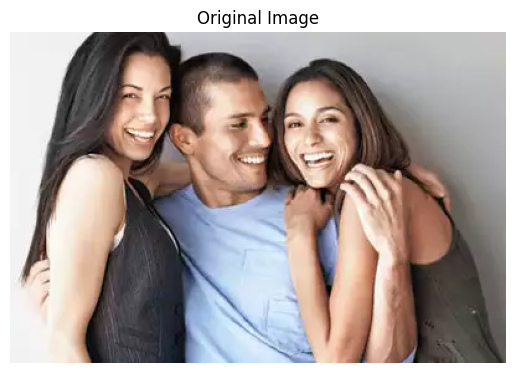

In [10]:
tracker.reset()

image = '/Users/thiagomachado/Documents/Programação/Python/src/Images/people.jpg'
cv2_image = cv2.imread(image)
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
PIL_image = Image.fromarray(cv2_image)

face_person_results, output_image = face_person_model.recognize(cv2_image)
face_to_person_map = face_person_results.face_to_person_map
genders = face_person_results.genders
ages = face_person_results.ages

face_person_results.associate_faces_with_persons()

face_bbox_idx = face_person_results.get_bboxes_inds("face")
person_bbox_idx = face_person_results.get_bboxes_inds("person")
yolo_results = face_person_results.yolo_results

print(f'Faces detected: {len(face_bbox_idx)}')
print(f'Persons detected: {len(person_bbox_idx)}')

plt.imshow(cv2_image)
plt.axis('off')
plt.title('Original Image')
plt.show()


0: 640x640 1 person, 90.9ms
Speed: 3.7ms preprocess, 90.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Person: 1
Gender: female
Age: 31.56
Emotion: happy

0: 640x640 1 person, 66.8ms
Speed: 1.7ms preprocess, 66.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Person: 2
Gender: female
Age: 22.19
Emotion: happy


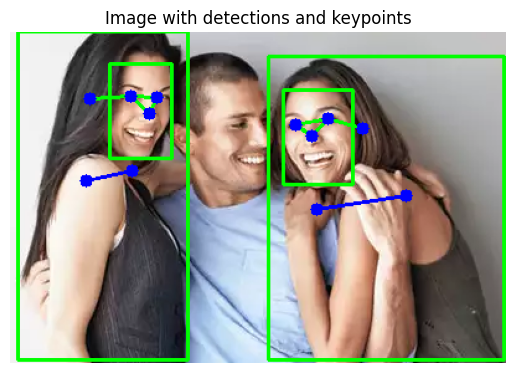

In [11]:
annotated_image = PIL_image.copy()
annotated_image = np.array(annotated_image)
detections = svt.get_ultralytics_detections(yolo_results[person_bbox_idx], tracker=tracker)
face_to_person_map_keys = list(face_to_person_map.keys())

def filter_emotion_tolerance(emotions:dict) -> str:
    emotions = pd.DataFrame(emotions)
    if (emotions[emotions['label'] == 'neutral']['score'].iloc[0] - emotions.iloc[0]['score']) > 0.2:
        label = 'neutral'
    label = emotions.iloc[0]['label']
    
    return label
    
for idx, (person_bbox, tracker_id) in enumerate(zip(detections.xyxy, detections.tracker_id)):
    person_idx = person_bbox_idx[idx]
    try:
        face_idx = int([k for k in face_to_person_map_keys if face_to_person_map[k] == person_bbox_idx[idx]][0])
        face_bbox = face_person_results.get_bbox_by_ind(face_idx)
        person_bbox = face_person_results.get_bbox_by_ind(person_idx)
        
        person_croped = face_person_results.crop_object(cv2_image,person_idx)
        person_croped_pose_results = pose_model(person_croped)
        ult.draw_keypoints(annotated_image, person_croped_pose_results, ofset=(int(person_bbox[0]), int(person_bbox[1])))
        
        face_croped = face_person_results.crop_object(cv2_image,face_idx)
        face_croped = cv2.cvtColor(face_croped, cv2.COLOR_BGR2RGB)
        
        PIL_image_croped = Image.fromarray(face_croped)
        emotion = pipe(PIL_image_croped)
        
        gender = genders[person_idx]
        age = ages[person_idx]
        label = f'#{tracker_id} {gender} {age} yo'
        emotion_label = filter_emotion_tolerance(emotion)
        
        print(f'Person: {tracker_id}')
        print(f'Gender: {gender}')
        print(f'Age: {age}')
        print(f'Emotion: {emotion_label}')
        
        cv2.rectangle(annotated_image, (int(face_bbox[0]), int(face_bbox[1])), (int(face_bbox[2]), int(face_bbox[3])), (0, 255, 0), 2)
        cv2.rectangle(annotated_image, (int(person_bbox[0]), int(person_bbox[1])), (int(person_bbox[2]), int(person_bbox[3])), (0, 255, 0), 2)
        
    except IndexError:
        continue
  
plt.imshow(annotated_image)
plt.axis('off')
plt.title('Image with detections and keypoints')
plt.show()